 ## Einleitung

Diese Notebook zeigt verschiedene Beispiele für die Klassifizierung von Früchten. Es werden verschiedene CNN Implementierungen mit Keras umgesetzt.

## Laden von benötigten Libraries

In [12]:
#Laden der benötigten Libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Daten laden und in Tensorflow Batches umwandeln

In [13]:
#Zugang zu eigenem Google Drive ermöglichen
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#Import und unzippen des ZipFile
import os
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/fruits-360_dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Exploratory Analysis


In [15]:
#Fileverzeichnis definiern
im_shape = (100,100)

TRAINING_DIR = "../content/fruits-360/Training"
TEST_DIR = "../content/fruits-360/Test"

seed = 80
BATCH_SIZE = 128

In [16]:
#Split test and validation
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [17]:
#data augmentation
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [18]:
# Training set
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Validation set
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Test set
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)


Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.
Classes: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kak

## Daten Übersicht / Visulisierung

In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

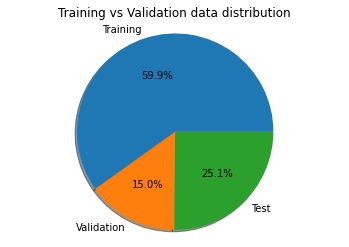

In [19]:
# Training, Test and validation - Verteilung der Images
labels = 'Training', 'Validation','Test'
sizes = [len(train_generator), len(validation_generator), len(test_generator)]

fig1, ax1 = plt.subplots()
plt.title('Training vs Validation data distribution')
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal') 
plt.show()

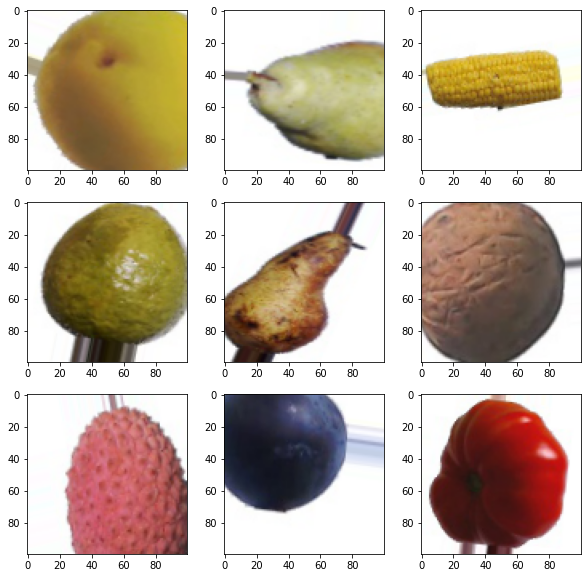

In [20]:
# Visualizing some examples
plt.figure(figsize=(10,10))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

## Einfaches CNN Model
Model mit einem Convolutional Block ohne zusätzlichen Dens Layer

In [21]:
#Model erstellen und Summary anschauen
model  =  Sequential()

model.add(Conv2D(16,(3,3),activation="relu",padding="same",input_shape=(100,100,3)))
model.add(Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))

model.add(Dense(131))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 150)               6000150   
                                                                 
 activation_2 (Activation)   (None, 150)               0         
                                                      

In [22]:
#Model trainieren und bestes Model abspeichern

#Callback um bestes Modell zu speichern
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h1',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
423/423 [==============================] - ETA: 0s - loss: 2.1485 - accuracy: 0.4583
Epoch 1: val_loss improved from inf to 0.77390, saving model to model.h1
INFO:tensorflow:Assets written to: model.h1/assets
423/423 [==============================] - 177s 413ms/step - loss: 2.1485 - accuracy: 0.4583 - val_loss: 0.7739 - val_accuracy: 0.7836
Epoch 2/10
423/423 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.8345
Epoch 2: val_loss improved from 0.77390 to 0.36265, saving model to model.h1
INFO:tensorflow:Assets written to: model.h1/assets
423/423 [==============================] - 175s 414ms/step - loss: 0.5254 - accuracy: 0.8345 - val_loss: 0.3627 - val_accuracy: 0.8960
Epoch 3/10
423/423 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.8971
Epoch 3: val_loss did not improve from 0.36265
423/423 [==============================] - 172s 407ms/step - loss: 0.3196 - accuracy: 0.8971 - val_loss: 0.3648 - val_accuracy: 0.9025
Epoch 4/

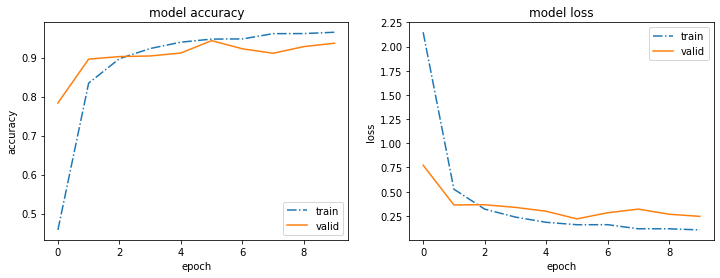

In [23]:
# Plotten der Entwicklung von Accuracy und Loss während des Trainings
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [25]:
#Tabelle erstellen mit der Valuation Accuracy am Ende des Trainings
import pandas as pd
acc=np.array(history.history['val_accuracy'])[-1]
loss=np.array(history.history['val_loss'])[-1]
res1 = pd.DataFrame(
          {'Acc' : acc, 'Loss' : loss}, index=['CNN Einfach']
)
pd.concat([res1])

,Acc,Loss
CNN Einfach,0.936756,0.244679


## CNN Komplex I
Model mit 2Convolution Blocks und mehr 2 zusätzlichen Dens Layers mit je 500 und 300 Neuronen

In [26]:
#Model erstellen und Summary anschauen
model  =  Sequential()

model.add(Conv2D(16,(3,3),activation="relu",padding="same",input_shape=(100,100,3)))
model.add(Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))

model.add(Dense(131))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [27]:
#Model trainieren und bestes Model abspeichern

#Callback um bestes Modell zu speichern
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h2',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
423/423 [==============================] - ETA: 0s - loss: 1.8392 - accuracy: 0.5045
Epoch 1: val_loss improved from inf to 0.56423, saving model to model.h2
INFO:tensorflow:Assets written to: model.h2/assets
423/423 [==============================] - 177s 416ms/step - loss: 1.8392 - accuracy: 0.5045 - val_loss: 0.5642 - val_accuracy: 0.8347
Epoch 2/10
423/423 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8750
Epoch 2: val_loss improved from 0.56423 to 0.32844, saving model to model.h2
INFO:tensorflow:Assets written to: model.h2/assets
423/423 [==============================] - 175s 414ms/step - loss: 0.3692 - accuracy: 0.8750 - val_loss: 0.3284 - val_accuracy: 0.9017
Epoch 3/10
423/423 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9334
Epoch 3: val_loss improved from 0.32844 to 0.31027, saving model to model.h2
INFO:tensorflow:Assets written to: model.h2/assets
423/423 [==============================] - 174s 412ms/step - l

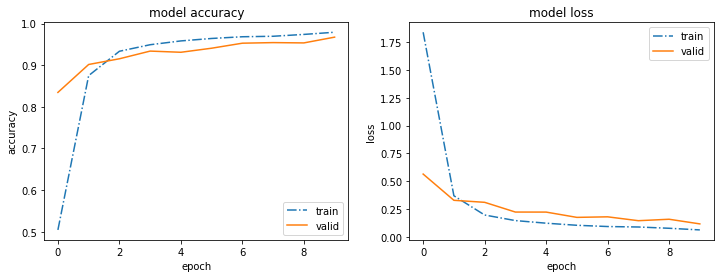

In [28]:
# Plotten der Entwicklung von Accuracy und Loss während des Trainings
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [29]:
#Tabelle erstellen mit der Valuation Accuracy am Ende des Trainings
acc=np.array(history.history['val_accuracy'])[-1]
loss=np.array(history.history['val_loss'])[-1]
res2 = pd.DataFrame(
          {'Acc' : acc, 'Loss' : loss}, index=['CNN Komplexer I']
)
pd.concat([res1, res2])

,Acc,Loss
CNN Einfach,0.936756,0.244679
CNN Komplexer I,0.967336,0.116320


## CNN Komplex II
Bei diesem Model wurde die Kernel Size angepasst und ein Dens Layer entfernt

In [30]:
#Model mit Kernel 10X10
model = Sequential()

model.add(Conv2D(16,(10, 10),padding='same',input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(Conv2D(16,(10, 10),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(10, 10),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32,(10, 10),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # vergleich mit SGD möglich
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 16)      4816      
                                                                 
 activation_7 (Activation)   (None, 100, 100, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 16)      25616     
                                                                 
 activation_8 (Activation)   (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        51232     
                                                      

In [32]:
#Model trainieren und bestes Model abspeichern

#Callback um bestes Modell zu speichern
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h3',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
423/423 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.8225
Epoch 1: val_loss improved from inf to 0.34216, saving model to model.h3
INFO:tensorflow:Assets written to: model.h3/assets
423/423 [==============================] - 176s 417ms/step - loss: 0.5333 - accuracy: 0.8225 - val_loss: 0.3422 - val_accuracy: 0.8740
Epoch 2/10
423/423 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.8767
Epoch 2: val_loss did not improve from 0.34216
423/423 [==============================] - 175s 413ms/step - loss: 0.3722 - accuracy: 0.8767 - val_loss: 0.3601 - val_accuracy: 0.8735
Epoch 3/10
423/423 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9032
Epoch 3: val_loss improved from 0.34216 to 0.21111, saving model to model.h3
INFO:tensorflow:Assets written to: model.h3/assets
423/423 [==============================] - 175s 415ms/step - loss: 0.2870 - accuracy: 0.9032 - val_loss: 0.2111 - val_accuracy: 0.9405
Epoch 4/

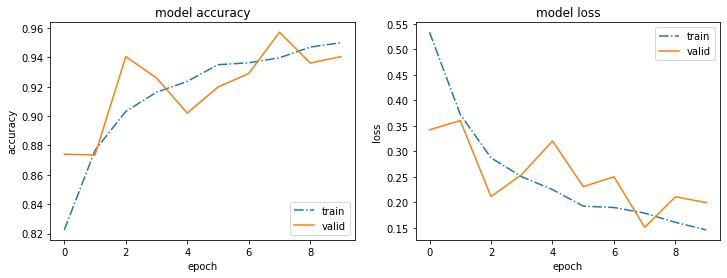

In [33]:
# Plotten der Entwicklung von Accuracy und Loss während des Trainings
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [34]:
#Tabelle erstellen mit der Valuation Accuracy am Ende des Trainings
acc=np.array(history.history['val_accuracy'])[-1]
loss=np.array(history.history['val_loss'])[-1]
res3 = pd.DataFrame(
          {'Acc' : acc, 'Loss' : loss}, index=['CNN Komplexer II']
)
pd.concat([res1, res2, res3])

,Acc,Loss
CNN Einfach,0.936756,0.244679
CNN Komplexer I,0.967336,0.116320
CNN Komplexer II,0.940476,0.199289


## CNN Komplex III
Bei diesem Model wurden anderen Neuronenanzahl gewählt und BatchSize vergrössert


In [35]:
img_rows, img_cols = 100, 100
kernel_size = (10, 10)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)
model = Sequential()

model.add(Conv2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # vergleich mit SGD möglich
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 8)       2408      
                                                                 
 activation_13 (Activation)  (None, 100, 100, 8)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 8)       6408      
                                                                 
 activation_14 (Activation)  (None, 100, 100, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 8)        0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 16)        12816     
                                                      

In [36]:
#Model trainieren und bestes Model abspeichern

#Callback um bestes Modell zu speichern
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h4',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
423/423 [==============================] - ETA: 0s - loss: 2.4178 - accuracy: 0.3551
Epoch 1: val_loss improved from inf to 0.85484, saving model to model.h4
INFO:tensorflow:Assets written to: model.h4/assets
423/423 [==============================] - 175s 411ms/step - loss: 2.4178 - accuracy: 0.3551 - val_loss: 0.8548 - val_accuracy: 0.7404
Epoch 2/10
423/423 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.7752
Epoch 2: val_loss improved from 0.85484 to 0.43540, saving model to model.h4
INFO:tensorflow:Assets written to: model.h4/assets
423/423 [==============================] - 174s 412ms/step - loss: 0.6800 - accuracy: 0.7752 - val_loss: 0.4354 - val_accuracy: 0.8739
Epoch 3/10
423/423 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.8569
Epoch 3: val_loss improved from 0.43540 to 0.38328, saving model to model.h4
INFO:tensorflow:Assets written to: model.h4/assets
423/423 [==============================] - 174s 411ms/step - l

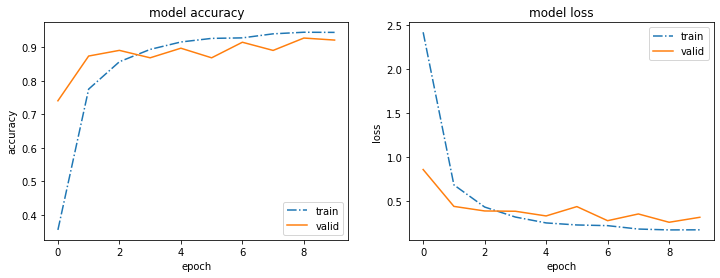

In [37]:
# Plotten der Entwicklung von Accuracy und Loss während des Trainings
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [38]:
#Tabelle erstellen mit der Valuation Accuracy am Ende des Trainings
acc=np.array(history.history['val_accuracy'])[-1]
loss=np.array(history.history['val_loss'])[-1]
res4 = pd.DataFrame(
          {'Acc' : acc, 'Loss' : loss}, index=['CNN Komplexer III']
)
pd.concat([res1, res2, res3, res4])

,Acc,Loss
CNN Einfach,0.936756,0.244679
CNN Komplexer I,0.967336,0.116320
CNN Komplexer II,0.940476,0.199289
CNN Komplexer III,0.921503,0.311193


## CNN Komplex IIII mit Dropout
Bei diesem Model wurde die Dropout Funktion gegen Overfitting eingesetzt.

In [39]:
img_rows, img_cols = 100, 100
kernel_size = (10, 10)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)
model = Sequential()

model.add(Conv2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 100, 100, 8)       2408      
                                                                 
 activation_19 (Activation)  (None, 100, 100, 8)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 8)       6408      
                                                                 
 activation_20 (Activation)  (None, 100, 100, 8)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 8)        0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 50, 50, 16)        12816     
                                                      

In [40]:
#Model trainieren und bestes Model abspeichern

#Callback um bestes Modell zu speichern
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
423/423 [==============================] - ETA: 0s - loss: 4.8303 - accuracy: 0.0162
Epoch 1: val_loss improved from inf to 4.45820, saving model to model.h5
423/423 [==============================] - 176s 413ms/step - loss: 4.8303 - accuracy: 0.0162 - val_loss: 4.4582 - val_accuracy: 0.0348
Epoch 2/10
423/423 [==============================] - ETA: 0s - loss: 2.4896 - accuracy: 0.3287
Epoch 2: val_loss improved from 4.45820 to 0.98190, saving model to model.h5
423/423 [==============================] - 175s 413ms/step - loss: 2.4896 - accuracy: 0.3287 - val_loss: 0.9819 - val_accuracy: 0.7109
Epoch 3/10
423/423 [==============================] - ETA: 0s - loss: 0.9920 - accuracy: 0.6833
Epoch 3: val_loss improved from 0.98190 to 0.57654, saving model to model.h5
423/423 [==============================] - 175s 413ms/step - loss: 0.9920 - accuracy: 0.6833 - val_loss: 0.5765 - val_accuracy: 0.8021
Epoch 4/10
423/423 [==============================] - ETA: 0s - loss: 0.6073 - a

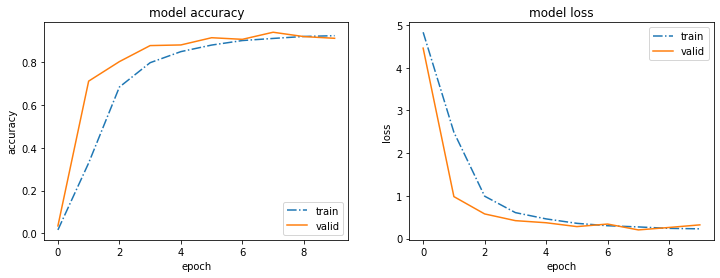

In [51]:
# Plotten der Entwicklung von Accuracy und Loss während des Trainings
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [52]:
#Tabelle erstellen mit der Valuation Accuracy am Ende des Trainings
acc=np.array(history.history['val_accuracy'])[-1]
loss=np.array(history.history['val_loss'])[-1]
res5 = pd.DataFrame(
          {'Acc' : acc, 'Loss' : loss}, index=['CNN Komplexer III mit Dropout']
)
pd.concat([res1, res2, res3, res4, res5])

,Acc,Loss
CNN Einfach,0.936756,0.244679
CNN Komplexer I,0.967336,0.116320
CNN Komplexer II,0.940476,0.199289
CNN Komplexer III,0.921503,0.311193
CNN Komplexer III mit Dropout,0.910937,0.320437


## CNN Komplex I mit Dropout
Zum Schluss haben wir das Beste Model von oben mit der Dropout Funktion erweitert. 

In [53]:
#Model erstellen und Summary anschauen
model  =  Sequential()

model.add(Conv2D(16,(3,3),activation="relu",padding="same",input_shape=(100,100,3)))
model.add(Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(300))
model.add(Activation('relu'))

model.add(Dense(131))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

In [54]:
#Model trainieren und bestes Model abspeichern

#Callback um bestes Modell zu speichern
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h2',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
423/423 [==============================] - ETA: 0s - loss: 1.9020 - accuracy: 0.4671
Epoch 1: val_loss improved from inf to 0.47914, saving model to model.h2
INFO:tensorflow:Assets written to: model.h2/assets
423/423 [==============================] - 178s 419ms/step - loss: 1.9020 - accuracy: 0.4671 - val_loss: 0.4791 - val_accuracy: 0.8624
Epoch 2/10
423/423 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.8383
Epoch 2: val_loss improved from 0.47914 to 0.30536, saving model to model.h2
INFO:tensorflow:Assets written to: model.h2/assets
423/423 [==============================] - 176s 417ms/step - loss: 0.4717 - accuracy: 0.8383 - val_loss: 0.3054 - val_accuracy: 0.8843
Epoch 3/10
423/423 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.9007
Epoch 3: val_loss improved from 0.30536 to 0.25800, saving model to model.h2
INFO:tensorflow:Assets written to: model.h2/assets
423/423 [==============================] - 177s 419ms/step - l

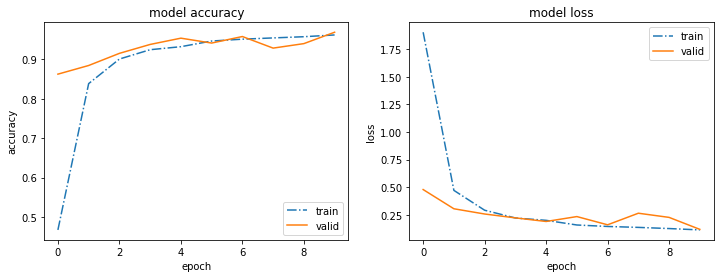

In [55]:
# Plotten der Entwicklung von Accuracy und Loss während des Trainings
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [57]:
#Tabelle erstellen mit der Valuation Accuracy am Ende des Trainings
acc=np.array(history.history['val_accuracy'])[-1]
loss=np.array(history.history['val_loss'])[-1]
res6 = pd.DataFrame(
          {'Acc' : acc, 'Loss' : loss}, index=['CNN Komplexer III mit Dropout']
)
pd.concat([res1, res2, res3, res4, res5, res6])

,Acc,Loss
CNN Einfach,0.936756,0.244679
CNN Komplexer I,0.967336,0.116320
CNN Komplexer II,0.940476,0.199289
CNN Komplexer III,0.921503,0.311193
CNN Komplexer III mit Dropout,0.910937,0.320437
CNN Komplexer III mit Dropout,0.968676,0.119068


## Model evaluieren
Das beste Model CNN Komplex I mit Dropout haben wir and Validation Daten und den Testdaten evaluiert.

In [59]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.h2')

In [60]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Val loss: 0.11852315068244934
Val accuracy: 0.9688194394111633


In [61]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Test loss: 0.11620311439037323
Test accuracy: 0.9720557332038879


In [67]:
#Tabelle erstellen mit der Valuation Accuracy am Ende des Trainings
score = model.evaluate_generator(test_generator)

res7 = pd.DataFrame(
          {'Test accuracy' : score[1], 'Test loss' : score[0]}, index=['Accuracy & Loss - Testdata']
)
pd.concat([res7])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


,Test accuracy,Test loss
Accuracy & Loss - Testdata,0.972056,0.116203


## Testeport und Klassifikationsmatrix

In [62]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.69      0.59      0.64       164
 Apple Crimson Snow       1.00      0.97      0.99       148
     Apple Golden 1       0.80      1.00      0.89       160
     Apple Golden 2       0.94      1.00      0.97       164
     Apple Golden 3       1.00      1.00      1.00       161
 Apple Granny Smith       1.00      1.00      1.00       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       0.98      1.00      0.99       164
        Apple Red 2       1.00      0.85      0.92       164
        Apple Red 3       0.97      1.00      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      0.88      0.94       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       0.88      1.00      0.93       164
            Avocado       1.00      1.00      1.00       143
 

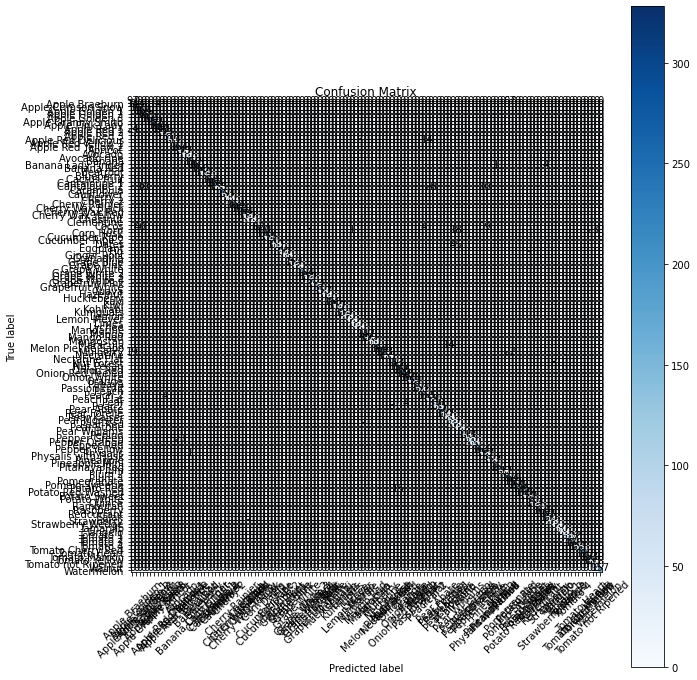

In [63]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix( cm, target_names, normalize=False, title='Confusion Matrix', )

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))